# This program attempts to predict the mutation score 

In [2]:
from sklearn import datasets
import pandas as pd

## Read and Process Dataframe

Combining data from the following analysis: 
* lazytracker.json
* 101_intersection.json
* 101_palindrome.json
* 101_sorting.json

Drop NA values
Drop "test_" functions

In [3]:
def process_json_file(filepath):
    sub_df = pd.read_json(filepath)
    sub_df = sub_df.dropna()
    sub_df = sub_df[~sub_df['function_name'].str.startswith("test_")]
    return sub_df

In [4]:
import os

In [5]:
dataframes = []
folder_path = "../json_analysis"

for filename in os.listdir(folder_path):
    if filename.endswith("json"):
        filepath = os.path.join(folder_path, filename)
        sub_df = process_json_file(filepath)
        sub_df.insert(0,"filename",filename)
        dataframes.append(sub_df)

df = pd.concat(dataframes, ignore_index=True)

In [6]:
df

,filename,function_name,function_scope,patterns,mutants,mutation_score
0,101_sorting.json,bubble_sort,21-38,"[{'lineno': 21, 'coloffset': 0, 'linematch': '...","[{'name': 'Mutant #167', 'line': 21, 'descript...",0.000000
1,101_sorting.json,insertion_sort,41-60,"[{'lineno': 41, 'coloffset': 0, 'linematch': '...","[{'name': 'Mutant #182', 'line': 44, 'descript...",0.000000
2,101_sorting.json,merge,63-93,"[{'lineno': 63, 'coloffset': 0, 'linematch': '...","[{'name': 'Mutant #191', 'line': 64, 'descript...",0.000000
3,101_sorting.json,generate_random_number,17-22,"[{'lineno': 17, 'coloffset': 0, 'linematch': '...","[{'name': 'Mutant #166', 'line': 18, 'descript...",0.000000
4,101_sorting.json,generate_random_container,25-33,"[{'lineno': 25, 'coloffset': 0, 'linematch': '...","[{'name': 'Mutant #170', 'line': 25, 'descript...",0.000000
5,101_sorting.json,run_sorting_algorithm,36-52,"[{'lineno': 36, 'coloffset': 0, 'linematch': '...","[{'name': 'Mutant #178', 'line': 36, 'descript...",0.000000
6,101_sorting.json,run_sorting_algorithm_experiment_campaign,55-81,"[{'lineno': 55, 'coloffset': 0, 'linematch': '...","[{'name': 'Mutant #187', 'line': 57, 'descript...",0.000000
7,101_sorting.json,listsorting,45-78,"[{'lineno': 45, 'coloffset': 0, 'linematch': '...","[{'name': 'Mutant #183', 'line': 46, 'descript...",0.000000
8,101_intersection.json,human_readable_boolean,30-36,"[{'lineno': 30, 'coloffset': 0, 'linematch': '...","[{'name': 'Mutant #11', 'line': 34, 'descripti...",0.000000
9,101_intersection.json,generate_random_container,39-47,"[{'lineno': 39, 'coloffset': 0, 'linematch': '...","[{'name': 'Mutant #13', 'line': 40, 'descripti...",33.333333


**Dropping all mutation_score with 'NA' values**

### Parsing data: check_ids and patterns

In [7]:
def extract_pattern_id(df):
    df['check_ids'] = df['patterns'].apply(lambda x: [pattern['check_id'] for pattern in x if 'check_id' in pattern])
    df['check_ids'] = df['check_ids'].apply(pd.unique)
    df['unique_patterns'] = df['patterns'].apply(lambda x: [pattern['pattern'] for pattern in x])
    df['unique_patterns'] = df['unique_patterns'].apply(pd.unique)
    return df

In [8]:
df = extract_pattern_id(df.copy())

/var/folders/wq/bl0_pfhx3y72c5nsrjqp6qph0000gn/T/ipykernel_2010/1785012781.py:3: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df['check_ids'] = df['check_ids'].apply(pd.unique)
/var/folders/wq/bl0_pfhx3y72c5nsrjqp6qph0000gn/T/ipykernel_2010/1785012781.py:5: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  df['unique_patterns'] = df['unique_patterns'].apply(pd.unique)


### Collect all patterns from the config files

In [9]:
import os
import ruamel.yaml

In [10]:

def get_patterns_from_yaml(filepath):
  """
  Extracts patterns from the 'pattern' key under the 'checks' key in a YAML file.

  Args:
      filepath: Path to the YAML file.

  Returns:
      A list of patterns found in the YAML file, or None if parsing fails.
  """
  try:
    with open(filepath) as f:
      yaml = ruamel.yaml.YAML(typ='safe', pure=True)  # Use new API for safe loading
      data = yaml.load(f)
      checks = data.get("checks")  # Get the 'checks' dictionary
      if checks:
        patterns = [check.get("pattern") for check in checks]  # Extract patterns from checks
        return patterns if any(patterns) else None  # Return only if patterns exist
      else:
        print(f"Warning: 'checks' key not found in YAML file: {filepath}")
        return None
  except ruamel.yaml.YAMLError as e:
    print(f"Error parsing YAML file '{filepath}': {e}")
    return None

In [11]:
def collect_config_patterns(config_dir):
  """
  Collects unique patterns from all YAML files in a directory.

  Args:
      config_dir: The directory containing the YAML files.

  Returns:
      A list of unique patterns found in the YAML files.
  """
  all_patterns = []

  # Check if config directory exists
  if not os.path.isdir(config_dir):
    raise ValueError(f"Directory '{config_dir}' does not exist.")
  for filename in os.listdir(config_dir):
    if filename.endswith(".yml"):
      filepath = os.path.join(config_dir, filename)
      patterns = get_patterns_from_yaml(filepath)
      if patterns:
        all_patterns.extend(patterns) #Extend list with patterns from each file
  #Remove duplicates using set
  config_patterns = list(set(all_patterns))

  return config_patterns

In [12]:
config_dir = "../Config"  # Replace with your actual directory path
config_patterns = collect_config_patterns(config_dir)

if config_patterns:
  print("Unique patterns found:",config_patterns)
else:
  print("No patterns found in the YAML files.")

Error parsing YAML file '../Config/checks.yml': while parsing a block collection
  in "../Config/checks.yml", line 2, column 3
expected <block end>, but found '<block sequence start>'
  in "../Config/checks.yml", line 258, column 4
Error parsing YAML file '../Config/newer.yml': while parsing a block mapping
  in "../Config/newer.yml", line 165, column 5
expected <block end>, but found '-'
  in "../Config/newer.yml", line 173, column 5
Unique patterns found: ['//FunctionDef[//(If/following-sibling::For | For/following-sibling::If)]', './/FunctionDef[//(If/following-sibling::For | For/following-sibling::If)]', './/FunctionDef[count(.//If | .//For | .//While | .//And | .//Or) > 10]', '//FunctionDef[@name="tp"]/body/Assign/value/Dict/keys/Name[preceding-sibling::Name/@id = @id]', './/FunctionDef/body//If[ancestor::If and not(parent::orelse)]', './/FunctionDef', '//FunctionDef//FunctionDef/ancestor::*', "//FunctionDef[@type='str']/body/* | //FunctionDef[@type='str']/body/Return", './/Functi

### Count pattern boolean values

In [13]:
#config pattern dictionary
predefined_patterns = {pattern:0 for pattern in config_patterns}

def update_pattern_counts(pattern_list):
    function_pattern = predefined_patterns.copy()
    for pattern in pattern_list:
        if pattern in function_pattern:
            function_pattern[pattern] += 1
    return function_pattern


In [14]:
df = df.assign(pattern_existence = df['unique_patterns'].apply(update_pattern_counts))

In [15]:
# catagorize mutation score 
low_threshold = 33
medium_threshold = 66

def map_to_category(score):
    """Maps a mutation score to a category (high, medium,low)"""
    if score < low_threshold:
        return "low"
    elif score < medium_threshold:
        return "medium"
    else:
        return "high"

In [16]:
df = df.assign(mutation_category = df['mutation_score'].apply(map_to_category))

**Current Dataset**

In [17]:
#Counts of mutation score categories
category_counts = df['mutation_category'].value_counts()
print(category_counts)

mutation_category
high      13
low       10
medium     4
Name: count, dtype: int64


In [18]:
df.to_csv("analysis.csv", index=False)

### Encoding Function Pattern list

In [19]:
def dict_to_list(predefined_patterns):
    pattern_list = [predefined_patterns[pattern] for pattern in predefined_patterns]
    return pattern_list

In [20]:
# Create a new column with pattern existence lists
df['pattern_bool'] = df['pattern_existence'].apply(dict_to_list)

In [21]:
df.to_csv("analysis.csv", index=False)

#### Create a new DataFrame with the pattern list as column names

In [22]:
def create_pattern_df(df):
    df_new = pd.DataFrame(columns=config_patterns+['mutation_category']+['filename'])
    for i in range(len(df)):
        mutation = df['mutation_category'].iloc[i]
        filename = df['filename'].iloc[i]
        pattern_dict = df['pattern_existence'].iloc[i]
        # Extract pattern values 
        pattern_value_list = list(pattern_dict.values())
        #add the pattern_value_list to df_new
        df_new.loc[i] = pattern_value_list + [mutation] + [filename]
    return df_new

In [23]:
pattern_df = create_pattern_df(df.copy())  # Avoid modifying original DataFrame

In [24]:
pattern_df

,//FunctionDef[//(If/following-sibling::For | For/following-sibling::If)],.//FunctionDef[//(If/following-sibling::For | For/following-sibling::If)],.//FunctionDef[count(.//If | .//For | .//While | .//And | .//Or) > 10],"//FunctionDef[@name=""tp""]/body/Assign/value/Dict/keys/Name[preceding-sibling::Name/@id = @id]",.//FunctionDef/body//If[ancestor::If and not(parent::orelse)],.//FunctionDef,//FunctionDef//FunctionDef/ancestor::*,//FunctionDef[@type='str']/body/* | //FunctionDef[@type='str']/body/Return,.//FunctionDef[not(args/arg/annotation) or not(returns)],".//FunctionDef//Call/func/Attribute[@attr=""keys""]",...,//FunctionDef//If/descendant::If,//FunctionDef//For[.//For],.//FunctionDef[body//comprehension/target/Name],"//FunctionDef//Call/func/Attribute[@attr=""keys""]",".//FunctionDef//Compare/left[@id=""input_dirs""]/following-sibling::Compare/ops/NotEq | .//FunctionDef//Compare/comparators[@id=""input_dirs""]/following-sibling::Compare/ops/NotEq",.//FunctionDef[count(body//Return) > 2],"//FunctionDef[@name=""init""]/body/Return","//Compare/left[@id=""input_dirs""]/following-sibling::Compare/ops/NotEq | //Compare/comparators[@id=""input_dirs""]/following-sibling::Compare/ops/NotEq",mutation_category,filename
0,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,low,101_sorting.json
1,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
2,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
3,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
5,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
6,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
7,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
8,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_intersection.json
9,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,medium,101_intersection.json


In [25]:
pattern_df.to_csv("pattern_df.csv", index=False)

### Leave-One-Project-Out Cross-Validationn(LOPO CV)

Using K-Fold Cross Validation to iterate K times, randomly select one project to hid (validation set) then combine the remaining projects into a single training set

In [26]:
pattern_df

,//FunctionDef[//(If/following-sibling::For | For/following-sibling::If)],.//FunctionDef[//(If/following-sibling::For | For/following-sibling::If)],.//FunctionDef[count(.//If | .//For | .//While | .//And | .//Or) > 10],"//FunctionDef[@name=""tp""]/body/Assign/value/Dict/keys/Name[preceding-sibling::Name/@id = @id]",.//FunctionDef/body//If[ancestor::If and not(parent::orelse)],.//FunctionDef,//FunctionDef//FunctionDef/ancestor::*,//FunctionDef[@type='str']/body/* | //FunctionDef[@type='str']/body/Return,.//FunctionDef[not(args/arg/annotation) or not(returns)],".//FunctionDef//Call/func/Attribute[@attr=""keys""]",...,//FunctionDef//If/descendant::If,//FunctionDef//For[.//For],.//FunctionDef[body//comprehension/target/Name],"//FunctionDef//Call/func/Attribute[@attr=""keys""]",".//FunctionDef//Compare/left[@id=""input_dirs""]/following-sibling::Compare/ops/NotEq | .//FunctionDef//Compare/comparators[@id=""input_dirs""]/following-sibling::Compare/ops/NotEq",.//FunctionDef[count(body//Return) > 2],"//FunctionDef[@name=""init""]/body/Return","//Compare/left[@id=""input_dirs""]/following-sibling::Compare/ops/NotEq | //Compare/comparators[@id=""input_dirs""]/following-sibling::Compare/ops/NotEq",mutation_category,filename
0,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,low,101_sorting.json
1,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
2,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
3,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
5,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
6,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
7,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_sorting.json
8,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,low,101_intersection.json
9,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,medium,101_intersection.json


#### Training on different algorithms

* Random Forest Classifier 
* Gradient Boosting Classifiers
* Support Vector Machine (SVM)

In [94]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

def evaluate_projects(pattern_df,algorithms):
    project_wise_f1 = {}
    project_wise_accuracy = {}
    for project_name in set(pattern_df['filename']):
        # Filter data for training (excluding current project)
        X_train = pattern_df[pattern_df['filename'] != project_name].drop(['filename','mutation_category'], axis=1)
        y_train = pattern_df[pattern_df['filename'] != project_name]['mutation_category']
    
        # Filter data for testing (current project)
        X_test = pattern_df[pattern_df['filename'] == project_name].drop(['filename','mutation_category'], axis=1)
        y_test = pattern_df[pattern_df['filename'] == project_name]['mutation_category']
        project_wise_f1[project_name] = {}
        project_wise_accuracy[project_name] = {}
        for name, model in algorithms.items():
            print()
            print(f"Project Targeted: {project_name}")
            print(f"Algorithm: {name}")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            print("All actual vs. predicted categories:")
            for i in range(len(y_test)):
                print(f"Sample {i+1}: Actual - {y_test.iloc[i]}, Predicted - {y_pred[i]}")
            f1 = f1_score(y_test, y_pred, average='weighted')
            project_wise_f1[project_name][name] = f1
            accuracy = accuracy_score(y_test, y_pred)
            project_wise_accuracy[project_name][name] = accuracy
            
            # Predict training and test set labels
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            
            # Predict probabilities of survival
            y_prob_train = model.predict_proba(X_train)
            y_prob_test = model.predict_proba(X_test)
            accuracy_train = np.mean(y_pred_train == y_train)
            accuracy_test = np.mean(y_pred_test == y_test)

            
            if name == "Random Forest":
                # Examining the model importances
                features = list(X_train)
                feature_importances = model.feature_importances_
                importances = pd.DataFrame(index=features)
                importances['importance'] = feature_importances
                importances['rank'] = importances['importance'].rank(ascending=False).values
                importances.sort_values('rank').head()
                print(importances)

                # SHAP explainer and beeswarm plot (for Random Forest only)
                explainer = shap.Explainer(model, X_train)
                shap_values = explainer(X_test, class_index = 1)
                shap.plots.beeswarm(shap_values)
                
    print('-'* 100)
    print("Calculate accuracy")
    print (f'Accuracy of predicting training data = {accuracy_train:0.3f}')
    print (f'Accuracy of predicting test data = {accuracy_test:0.3f}')
    print('-'* 100)
    print("Model importance for Random Forest: SAVED")
    importances.to_csv("rf_importance.csv", index=False)
    return project_wise_f1, project_wise_accuracy
    

In [95]:
algorithms = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier()
}
project_wise_f1, project_wise_accuracy = evaluate_projects(pattern_df.copy(), algorithms)


Project Targeted: 101_intersection.json
Algorithm: Random Forest
All actual vs. predicted categories:
Sample 1: Actual - low, Predicted - high
Sample 2: Actual - medium, Predicted - high
Sample 3: Actual - high, Predicted - high
Sample 4: Actual - high, Predicted - high
Sample 5: Actual - high, Predicted - high
Sample 6: Actual - high, Predicted - high
Sample 7: Actual - low, Predicted - high
                                                    importance  rank
//FunctionDef[//(If/following-sibling::For | Fo...    0.205064   2.0
.//FunctionDef[//(If/following-sibling::For | F...    0.000000  37.5
.//FunctionDef[count(.//If | .//For | .//While ...    0.000000  37.5
//FunctionDef[@name="tp"]/body/Assign/value/Dic...    0.000000  37.5
.//FunctionDef/body//If[ancestor::If and not(pa...    0.000000  37.5
...                                                        ...   ...
//FunctionDef//Call/func/Attribute[@attr="keys"]      0.000000  37.5
.//FunctionDef//Compare/left[@id="input_dirs"]/... 

TypeError: TreeExplainer.__call__() got an unexpected keyword argument 'class_index'

In [164]:
sum_rf = 0
sum_gb = 0
sum_svc = 0
sum_knn = 0
count= 0
print("Project-wise F1-Scores:")
print("-" * 100)  # Adjust width for better alignment
print("{:<25} | {:>15} | {:>15} | {:>15}| {:<10}|".format("Project Name", "Random Forest", "Gradient Boosting", "Support Vector Machine", "KNN"))
print("-" * 100)
for project, scores in project_wise_f1.items():
  print("{:<25} | {:>15.4f} | {:>15.4f} | {:>15.4f}| {:>9.4f}|".format(project, scores.get("Random Forest", 0), scores.get("Gradient Boosting", 0), scores.get("Support Vector Machine", 0), round(scores.get("KNN", 0), 4)))  # Round KNN score to 4 decimal places
  count+= 1
  sum_rf += scores.get("Random Forest", 0)
  sum_gb += scores.get("Gradient Boosting", 0)
  sum_svc += scores.get("Support Vector Machine", 0)
  sum_knn += scores.get("KNN", 0)
print("-" * 100)
print("{:<25} | {:>15.4f} | {:>15.4f} | {:>15.4f}| {:>9.4f}|".format("Average F1-score", sum_rf/count, sum_gb/count,sum_svc/count, sum_knn/count))


Project-wise F1-Scores:
----------------------------------------------------------------------------------------------------
Project Name              |   Random Forest | Gradient Boosting | Support Vector Machine| KNN       |
----------------------------------------------------------------------------------------------------
101_sorting.json          |          0.0000 |          0.0000 |          0.0000|    0.0000|
lazytracker.json          |          0.4848 |          0.4848 |          0.0000|    0.5926|
101_intersection.json     |          0.4156 |          0.4156 |          0.4156|    0.4156|
101_palindrome.json       |          0.1667 |          0.2222 |          0.1667|    0.2222|
----------------------------------------------------------------------------------------------------
Average F1-score          |          0.2668 |          0.2807 |          0.1456|    0.3076|


In [165]:
sum_rf = 0
sum_gb = 0
sum_svc = 0
count= 0
# Print project-wise accuracy scores 
print("\nProject-wise Accuracy Scores:")
print("-" * 80)
print("{:<25} | {:>15} | {:>15} | {:>15}".format("Project Name", "Random Forest", "Gradient Boosting", "Support Vector Machine"))
print("-" * 80)
for project, scores in project_wise_accuracy.items():
    print("{:<25} | {:>15.4f} | {:>15.4f} | {:>15.4f}".format(project, scores["Random Forest"], scores["Gradient Boosting"], scores["Support Vector Machine"]))
    count+= 1
    sum_rf += scores.get("Random Forest", 0)
    sum_gb += scores.get("Gradient Boosting", 0)
    sum_svc += scores.get("Support Vector Machine", 0)
print("-" * 80)
print("{:<25} | {:>15.4f} | {:>15.4f} | {:>15.4f}".format("Average F1-score", sum_rf/count, sum_gb/count,sum_svc/count))



Project-wise Accuracy Scores:
--------------------------------------------------------------------------------
Project Name              |   Random Forest | Gradient Boosting | Support Vector Machine
--------------------------------------------------------------------------------
101_sorting.json          |          0.0000 |          0.0000 |          0.0000
lazytracker.json          |          0.3333 |          0.3333 |          0.0000
101_intersection.json     |          0.5714 |          0.5714 |          0.5714
101_palindrome.json       |          0.3333 |          0.3333 |          0.3333
--------------------------------------------------------------------------------
Average F1-score          |          0.3095 |          0.3095 |          0.2262


<function matplotlib.pyplot.xticks(ticks=None, labels=None, *, minor=False, **kwargs)>

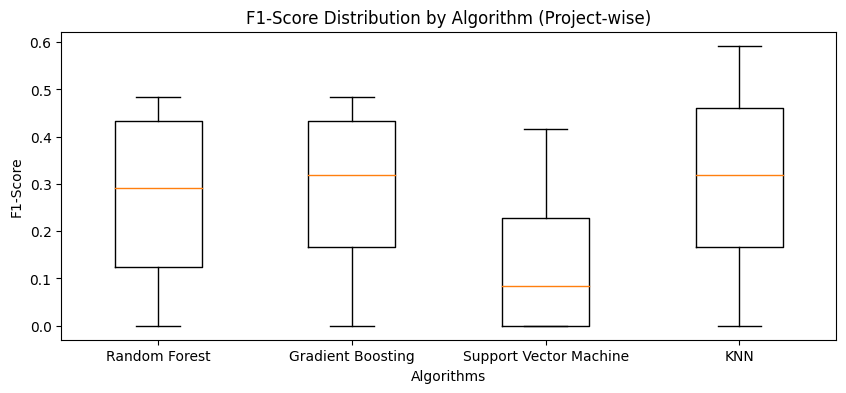

In [168]:
# Collect F1-scores for box plot
f1_scores_by_algorithm = {}
for algorithm, _ in algorithms.items():
  f1_scores_by_algorithm[algorithm] = []
  for project, scores in project_wise_f1.items():
    f1_scores_by_algorithm[algorithm].append(scores[algorithm])

# Create box plot
plt.figure(figsize=(10, 4))
plt.boxplot(f1_scores_by_algorithm.values(), labels=f1_scores_by_algorithm.keys())
plt.xlabel("Algorithms")
plt.ylabel("F1-Score")
plt.title("F1-Score Distribution by Algorithm (Project-wise)")
plt.xticks